In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('test_data.csv')

In [3]:
print(list(df))

['time', 'event', 'ad_cost_type', 'has_video', 'agency_union_id', 'client_union_id', 'campaign_union_id', 'ad_id', 'platform', 'date']


In [4]:
ac = df[['time', 'date', 'ad_id']].groupby('date').size().reset_index(name='count')

In [5]:
print(ac)

          date  count
0   2019-04-01   5172
1   2019-04-02   5269
2   2019-04-03   5357
3   2019-04-04   5108
4   2019-04-05   5305
5   2019-04-06   3955
6   2019-04-07   4091
7   2019-04-08   8902
8   2019-04-09   7963
9   2019-04-10   7098
10  2019-04-11  18259
11  2019-04-12  10740
12  2019-04-13  10999
13  2019-04-14   8656
14  2019-04-15   7457
15  2019-04-16   7766


In [6]:
ac.describe()

,count
count,16.00000
mean,7631.06250
std,3574.81702
min,3955.00000
25%,5244.75000
50%,7277.50000
75%,8717.50000
max,18259.00000


## 1. Строим график

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
ylabel = 'Количество действий с рекламными объявлениями'
xlabel = 'Дни'
title = 'Распределение действий с рекламными объявлениями'

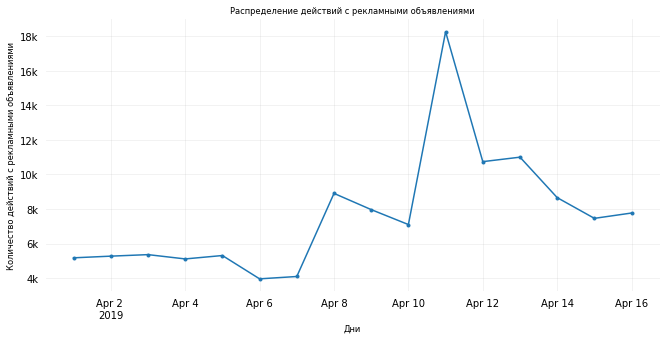

In [9]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(ac['date'], ac['count'], '.-')

# titles and labels
plt.xlabel(xlabel, fontsize='small')
plt.ylabel(ylabel, fontsize='small')
plt.title(title, fontsize='small')
plt.grid(alpha=0.2)

# ticks
yticks = ax.get_yticks()
ax.set_yticklabels([f'{int(x/1000)}k' for x in yticks])
plt.xticks(range(1, 16, 2), ['Apr 2 \n2019'] + [f'Apr {x}' for x in range(4, 18, 2)])
plt.tick_params(top=False, bottom=False, left=False, right=False)

# boarders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Uncomment this to save png file
# fig.savefig("events_dist.png", dpi=500)
plt.show()

## 2. Ищем причину скачка ивентов


In [10]:
df2 = df.groupby(['date', 'event']).size().reset_index(name='count')

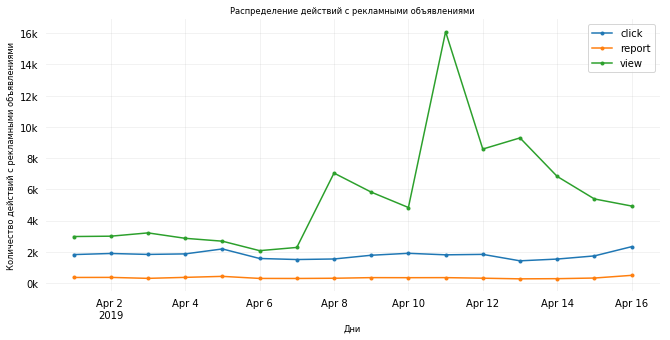

In [11]:
fig2, ax2 = plt.subplots(figsize=(11, 5))
for event in df2['event'].unique():
    ax2.plot(df2[df2['event'] == event]['date'], df2[df2['event'] == event]['count'], '.-', label=event)
# titles and labels
plt.xlabel(xlabel, fontsize='small')
plt.ylabel(ylabel, fontsize='small')
plt.title(title, fontsize='small')
ax2.grid(alpha=0.2)
ax2.legend()

# ticks
yticks = ax2.get_yticks()
ax2.set_yticklabels([f'{int(x/1000)}k' for x in yticks])

plt.xticks(range(1, 16, 2), ['Apr 2 \n2019'] + [f'Apr {x}' for x in range(4, 18, 2)])
plt.tick_params(top=False, bottom=False, left=False, right=False)

# boarders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

На этом графике видно, что значимо увеличилось только количество просмотров.

Возможно, увеличение просмотров связано с новой рекламной кампанией:

In [12]:
campaign_df = df.groupby(['campaign_union_id']).size().reset_index(name='count').sort_values('count', ascending=False)
print(campaign_df[:10])

      campaign_union_id  count
12109    campaign_49554  47739
12107    campaign_47269   1867
12115     campaign_5822   1012
7137       campaign_387    794
2115      campaign_1181    698
12112     campaign_5131    687
130     campaign_102754    663
4486     campaign_24261    650
5451      campaign_3021    616
12299    campaign_99643    577


По такой статистике видно, что большая часть просмотров приходится на campaign_49554.

In [13]:
# all actions excluding campaign_49554
nca = df[df['campaign_union_id'] != 'campaign_49554'].groupby('date').size().reset_index(name='count')

In [14]:
nca.describe()

,count
count,16.000000
mean,4647.375000
std,703.698124
min,3406.000000
25%,4078.750000
50%,4804.000000
75%,5124.000000
max,5909.000000


Если не учитывать campaign_49554, получаются достаточно ровные цифры от 3 до 6 тысяч взаимодействий.

Изучим поподробнее campaign_49554:

In [15]:
campaign_ads = df[df['campaign_union_id'] == 'campaign_49554']['ad_id'].unique()

В рекламную кампанию 49554 входять объявления со следющими id:

In [16]:
campaign_ads

array(['ad_49564', 'ad_49554', 'ad_49556', 'ad_49560', 'ad_50872'],
      dtype=object)

In [17]:
ads_df = df.groupby(['ad_id']).size().reset_index(name='count').sort_values('count', ascending=False)[:10]
ads_df['part of campaign 49554'] = ads_df['ad_id'].apply(lambda x: True if x in campaign_ads else False)

In [18]:
print(ads_df)

          ad_id  count  part of campaign 49554
17441  ad_49554  27500                    True
17442  ad_49556   8218                    True
17443  ad_49560   7496                    True
17444  ad_49564   4491                    True
17414  ad_47269   1867                   False
18046  ad_99643    577                   False
17545   ad_7701    559                   False
7324   ad_21831    491                   False
11782    ad_387    461                   False
3917    ad_1181    441                   False


Видно, что большая часть взаимодействий связана с малым числом рекламных объявлений
И четыре самых популярных рекламных объявления входят в кампанию 49554

In [19]:
top_ads = ads_df.sort_values('count', ascending=False)[:4]['ad_id'].values

In [20]:
print(df[df['ad_id'].isin(top_ads)]['agency_union_id'].unique())

['agency_2']


Все эти рекламные объявления принадлежат одному рекламному агенству

In [21]:
print(df[df['ad_id'].isin(top_ads)]['client_union_id'].unique())

['client_47270']


И для одного клиента

In [22]:
print(df[df['ad_id'].isin(top_ads)]['ad_cost_type'].unique())

['CPC']


По модели CPC — траты за клик, а как мы уже выяснили, зничительно выросли просмотры, но не клики.

## 3. Как автоматически детектировать аномальные изменения метрик на графиках рекламной статистики?

In [23]:
import time


def anomaly_warning():
    # Notification logic here
    print("Something strange is going on! Look at the data, please!")
    

def get_data():
    # Data is recieved here (from database or read from csv, etc.)
    df = pd.read_csv('test_data.csv')
    return df


def find_anomaly(df, period, end_date=None):
    # This function desides whether data has anomalies in it
    period *= 3600
    if not end_date:
        end_date = max(df['date'])
    
    # получаем время окончания последнего периода
    df.loc[:] = df[df['date'] <= end_date]
    t = max(df['time'])    
    days = len(df['date'].unique())
    
    # группируем по периодам
    df.loc[:, 'time'] = df['time'].apply(lambda x: t - ((t - x) // int(period)) * period)
    df = df[['time', 'ad_id']].groupby('time').size().reset_index(name='count')
    
    # берем аналогичные временные периоды за другие дни
    df = df[df['time'].isin([t - i * 86400 for i in range(days)])]
    
    # получаем статистику по этим периодам
    stats = df[df['time'] < t].describe()
    mean, std = stats['count'][1], stats['count'][2]
    
    # используем правило 3 или 2 сигм для нахождения аномалий
    current_interactions_number = df['count'].iloc[-1]
    if not (mean + 2 * std > current_interactions_number > mean - 2 * std):
        return True
    return False
    
    

In [24]:
def anomaly_check(period=24., end_date=None, repetitions_num=1):
    """
    Checks ad events for anomalies
    :param period: How often to check in hours(for example every 4 hours).
    :param repetitions_num: How many times to check.
    """
    for _ in range(repetitions_num):
        df = get_data()
        if find_anomaly(df, period, end_date):
            anomaly_warning()
            
        # uncomment this to run several times with a delay
        # time.sleep(period * 3600) 
        

In [26]:
anomaly_check(period=24, end_date='2019-04-11')

Something strange is going on! Look at the data, please!
